In [1]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# Load data
mu = pd.read_json('../Results/processed/mean_returns.json', typ='series')
cov = pd.read_csv('../Results/processed/cov_matrix.csv', index_col=0)
tickers = pd.read_csv('../Results/processed/tickers.txt', header=None)[0].tolist()

mu_vec = mu.loc[tickers].values
Sigma = cov.loc[tickers, tickers].values + 1e-8 * np.eye(len(tickers))

# Optimization
lam = 10
x = cp.Variable(len(tickers))
objective = cp.Minimize(cp.quad_form(x, Sigma) - lam * (mu_vec @ x))
constraints = [cp.sum(x) == 1, x >= 0, x <= 0.3]
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.OSQP)

weights = x.value
portfolio_return = float(mu_vec @ weights)
portfolio_risk = float(np.sqrt(weights @ Sigma @ weights))

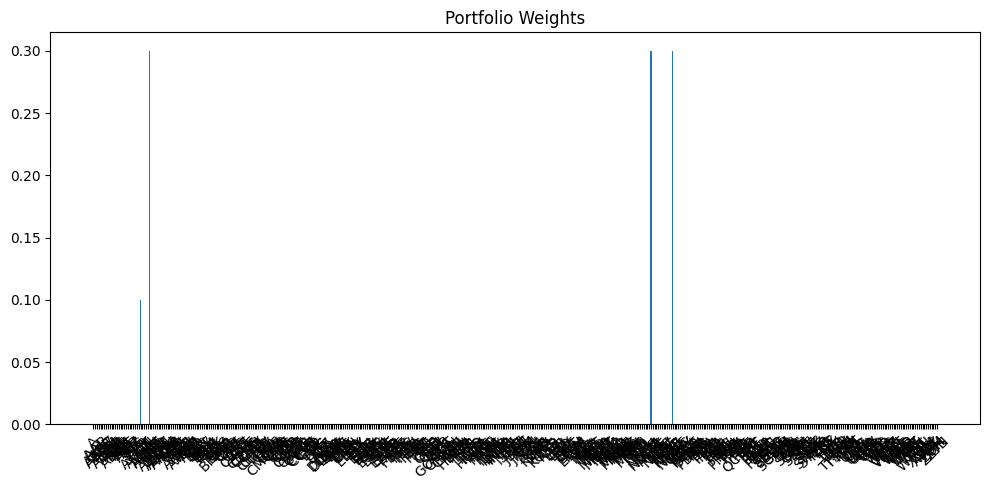

In [10]:
plt.figure(figsize=(10,5))
plt.bar(tickers, weights)
plt.xticks(rotation=45)
plt.title('Portfolio Weights')
plt.tight_layout()
plt.show()

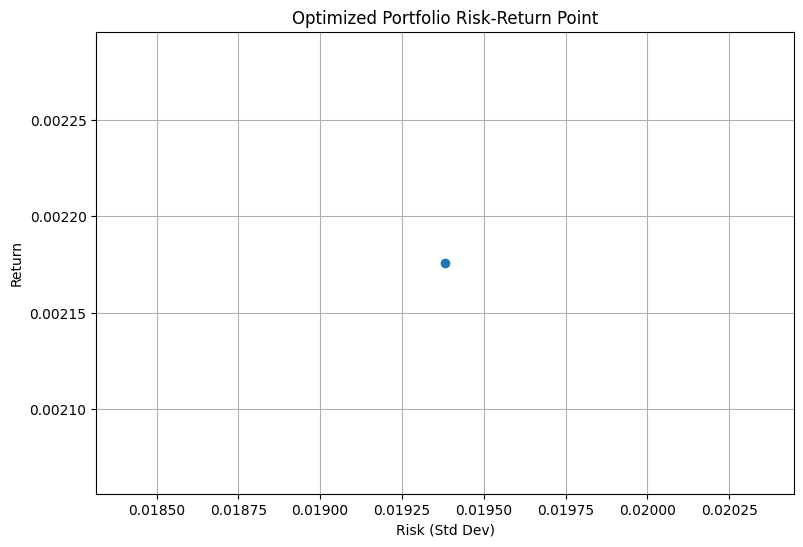

In [6]:
plt.figure(figsize=(9,6))
plt.scatter([portfolio_risk], [portfolio_return])
plt.xlabel('Risk (Std Dev)')
plt.ylabel('Return')
plt.title('Optimized Portfolio Risk-Return Point')
plt.grid(True)
plt.show()